In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
datapath = '/content/gdrive/My Drive/Personal/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!pip install flair

In [6]:
!pip install keras_Self_attention

In [0]:
#importing required libraries
#Reference: https://github.com/amsuhane/Humour-Detection-in-English-Hindi-Code-Mixed-Text
from __future__ import print_function
import numpy as np
from flair.data import Sentence
import re
from flair.embeddings import BertEmbeddings
import sklearn
from sklearn.metrics import classification_report
from keras_self_attention import SeqSelfAttention
from keras.layers import GRU
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.preprocessing import sequence

In [0]:
#Import the train and test data
train= [[]]
train_label =['negative']
train_ID = []
with open (datapath + "nlp assignment 3/train.txt") as file:
   line = file.readline()
   for cnt, line in enumerate(file):
     if len(line.split())== 2 :
       if (len(line.split()[1]) != "O"):
         train[-1].append(line.split())
     if len(line.split()) == 3:
       train.append([])
       train_label.append(line.split()[2])
       train_ID.append(line.split()[1])
   

In [0]:
test= [[]]
test_label = ['neutral']
test_ID = []
with open (datapath + "nlp assignment 3/test.txt") as file:
   line = file.readline()
   for cnt, line in enumerate(file):
     if  len(line.split())==2:
       if (len(line.split()[1]) != "O"):
         test[-1].append(line.split())
     if len(line.split()) ==3:
       test.append([])
       test_label.append(line.split()[2])
       test_ID.append(line.split()[1])


In [0]:
label_dict = {'positive': [1,0,0], 'neutral': [0,1,0], 'negative': [0,0,1]}

train_label_encode = []
for word in train_label:
  train_label_encode.append(label_dict[word])

test_label_encode = []
for word in test_label:
  test_label_encode.append(label_dict[word])

train_label_encode = np.array(train_label_encode)
test_label_encode = np.array(test_label_encode)

In [0]:
train_data = []
for i in range(len(train)):
  sent = " ".join([j[0] for j in train[i]])
  train_data.append(sent)

In [0]:
test_data = []
for i in range(len(test)):
  sent = " ".join([j[0] for j in test[i]])
  test_data.append(sent)

In [0]:
#Preprocessing
for i in range(len(train_data)):
  string = train_data[i]
  string = re.sub(r"(http)[^\s]*", "",string )
  string = re.sub(r"@[^\s]*", "" , string)
  string = re.sub(r"#[^\s]*", "", string)
  string = re.sub(r"(pic.twitter)[^\s]*", "", string)
  string = re.sub(r":[a-zA-Z0-9\s]", "", string)
  string = re.sub(r'[^a-zA-Z0-9\s]', "", string)
  string = string.lower()
  train_data[i] = string
for i in range(len(test_data)):
  string = test_data[i]
  string = re.sub(r"(http)[^\s]*", "",string )
  string = re.sub(r"@[^\s]*", "" , string)
  string = re.sub(r"#[^\s]*", "", string)
  string = re.sub(r"(pic.twitter)[^\s]*", "", string)
  string = re.sub(r":[a-zA-Z0-9\s]", "", string)
  string = re.sub(r'[^a-zA-Z0-9\s]', "", string)
  string = string.lower()
  test_data[i] = string

In [0]:
emd_bert = BertEmbeddings("bert-base-cased")

In [0]:
train_data_emd = []
for sent in train_data:
  sentence = Sentence(sent)
  train_data_emd.append(emd_bert.embed(sentence))

test_data_emd = []
for sent in test_data:
  sentence = Sentence(sent)
  test_data_emd.append(emd_bert.embed(sentence))

In [0]:
BertEmd_train= []
for i in train_data_emd:
  l=[]
  for j in i[0]:
    l.append(np.array(j.embedding.cpu()))
  BertEmb_train.append(np.array(l))

BertEmd_test= []
for i in test_data_emd:
  l=[]
  for j in i[0]:
    l.append(np.array(j.embedding.cpu()))
  BertEmb_test.append(np.array(l))

In [0]:
np.save("BertEmd_train",  BertEmd_train, allow_pickle=True, fix_imports=True)
np.save("BertEmd_test",  BertEmd_test, allow_pickle=True, fix_imports=True)

In [0]:
BertEmd_test = np.load(datapath + "BertEmd_test.npy", allow_pickle = True, fix_imports = True)

In [0]:
BertEmd_train = np.load(datapath + "BertEmd_train.npy", allow_pickle = True, fix_imports = True)

In [0]:
maximum_train_length= max([len(tweet.split()) for tweet in train_data])
maximum_test_length= max([len(tweet.split()) for tweet in test_data])

In [0]:
BertEmd_train = sequence.pad_sequences(BertEmd_train, maxlen=31)
BertEmd_test = sequence.pad_sequences(BertEmd_test, maxlen=31)

In [33]:
model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(31, 3072)))
model.add(SeqSelfAttention(attention_activation='relu'))
model.add(GRU(5, dropout=0.5, recurrent_dropout=0.5, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(BertEmd_train, train_label_encode, validation_split=0.2,	batch_size=32, epochs=12)

Train on 12104 samples, validate on 3027 samples
Epoch 1/12
12104/12104 [==============================] - 71s 6ms/step - loss: 1.0173 - acc: 0.4703 - val_loss: 0.9433 - val_acc: 0.5368
Epoch 2/12
12104/12104 [==============================] - 67s 6ms/step - loss: 0.9289 - acc: 0.5503 - val_loss: 0.9150 - val_acc: 0.5428
Epoch 3/12
12104/12104 [==============================] - 67s 6ms/step - loss: 0.8707 - acc: 0.5882 - val_loss: 0.8982 - val_acc: 0.5576
Epoch 4/12
12104/12104 [==============================] - 67s 6ms/step - loss: 0.8223 - acc: 0.6248 - val_loss: 0.9090 - val_acc: 0.5633
Epoch 5/12
12104/12104 [==============================] - 67s 6ms/step - loss: 0.7505 - acc: 0.6739 - val_loss: 1.0183 - val_acc: 0.5206
Epoch 6/12
12104/12104 [==============================] - 67s 6ms/step - loss: 0.6886 - acc: 0.7172 - val_loss: 1.0087 - val_acc: 0.5378
Epoch 7/12
12104/12104 [==============================] - 67s 6ms/step - loss: 0.6210 - acc: 0.7575 - val_loss: 1.0891 - val_acc:

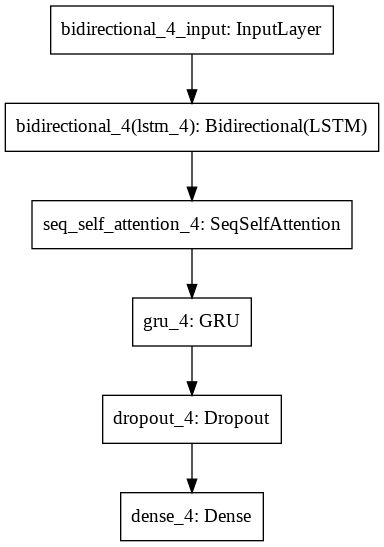

In [37]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [38]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 31, 128)           1606144   
_________________________________________________________________
seq_self_attention_4 (SeqSel (None, 31, 128)           8257      
_________________________________________________________________
gru_4 (GRU)                  (None, 5)                 2010      
_________________________________________________________________
dropout_4 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 18        
Total params: 1,616,429
Trainable params: 1,616,429
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.evaluate(BertEmd_test,test_label_encode)

1869/1869 [==============================] - 4s 2ms/step


[1.4620364133912398, 0.5377207063238145]

In [0]:
y_pred = model.predict_classes(BertEmd_test, batch_size = 10, verbose = 0)

In [0]:
y_dict = {0: [1,0,0], 1 : [0,1,0], 2: [0,0,1]}

test_pred = []
for i in y_pred:
  test_pred.append(y_dict[i])

test_pred = np.array(test_pred)

In [44]:
sklearn.metrics.classification_report(test_label_encode, test_pred)

'              precision    recall  f1-score   support\n\n           0       0.60      0.53      0.56       582\n           1       0.50      0.59      0.54       754\n           2       0.54      0.47      0.51       533\n\n   micro avg       0.54      0.54      0.54      1869\n   macro avg       0.55      0.53      0.54      1869\nweighted avg       0.54      0.54      0.54      1869\n samples avg       0.54      0.54      0.54      1869\n'